-- A. Nambiar 2/18/2022

done for fun and practice

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [9]:
pd.set_option('display.max_rows', 60)

In [116]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

# Import Data

In [11]:
df = pd.read_csv("nuforc_reports.csv")

## Data Source:

National UFO Reporting Center: "Dedicated to the collection and dissemination of objective UFO data"

Anonymous sources can file UFO Sightings through an Online Report Form

## *** Note: Data Limitations 

The data source are varied, anonymous, and random. The data collection is not validated and does not have a consistent process.

Proceed anyways since this project is for fun!

# Data Cleaning

## Data inspection

#### missing values in most columns but enough to proceed

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138018 entries, 0 to 138017
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   summary         137948 non-null  object 
 1   country         137794 non-null  object 
 2   city            137611 non-null  object 
 3   state           128648 non-null  object 
 4   date_time       135372 non-null  object 
 5   shape           131786 non-null  object 
 6   duration        131243 non-null  object 
 7   stats           138018 non-null  object 
 8   report_link     138018 non-null  object 
 9   text            137984 non-null  object 
 10  posted          135372 non-null  object 
 11  city_latitude   113060 non-null  float64
 12  city_longitude  113060 non-null  float64
dtypes: float64(2), object(11)
memory usage: 13.7+ MB


## Drop unneccesary/ repetitive columns

In [13]:
df = df.drop(['text', 'stats', 'report_link', 
              'posted', 'summary'], axis=1)

In [15]:
df

,country,city,state,date_time,shape,duration,city_latitude,city_longitude
0,USA,Sisters,OR,2021-05-15T22:36:00,cigar,4 minutes,44.315600,-121.517500
1,USA,Sarasota,FL,2021-05-10T22:00:00,other,2 minutes,27.354801,-82.508583
2,USA,Cleveland,TN,2021-05-05T22:35:00,light,10 minutes,35.146426,-84.851657
3,USA,Galway,NY,2020-10-16T18:25:00,circle,5 mins,43.022500,-74.026300
4,USA,Downingtown,PA,2021-06-18T01:00:00,circle,1 hour,40.014600,-75.713600
...,...,...,...,...,...,...,...,...
138013,USA,San Diego,CA,2020-02-12T13:00:00,NaN,15 seconds,32.836187,-117.162505
138014,USA,Ellenton,FL,2020-02-12T16:30:00,sphere,2 seconds MAX,27.542800,-82.503600
138015,USA,Driggs,ID,2020-02-12T18:30:00,changing,30 minutes,43.727300,-111.125300
138016,USA,Orem,UT,2020-02-12T21:00:00,light,15 minutes,40.277458,-111.668223


## 'Duration' column not formatted: clean, make numerical

In [14]:
df['duration'] = df['duration'].astype(str)

In [15]:
import re

def duration_to_seconds(duration):
    # Extract the duration value and time unit
    match = re.match(r'(\d+)(?:\s*(?:-|to)\s*(\d+))?\s*(second?|seconds?|Seconds?|Second?|sec?|Sec?|Secs?|secs?|min?|MINETS?|minute?|mins?|minutes?|Minutes?|Minute?|hour?|Hours?|Hour?|hr?|hours?|hrs?)$', duration, re.IGNORECASE)
    if match is None:
        return None

    start, end, time_unit = match.groups()

    # Convert the duration value(s) to seconds based on the time unit
    if time_unit in ['sec', 'second', 'seconds']:
        start_sec = int(start)
        if end is None:
            end_sec = start_sec
        else:
            end_sec = int(end)
        duration_seconds = (start_sec + end_sec) / 2
    elif time_unit in ['min', 'minute', 'minutes']:
        start_sec = int(start) * 60
        if end is None:
            end_sec = start_sec
        else:
            end_sec = int(end) * 60
        duration_seconds = (start_sec + end_sec) / 2
    elif time_unit in ['hour', 'hours']:
        start_sec = int(start) * 3600
        if end is None:
            end_sec = start_sec
        else:
            end_sec = int(end) * 3600
        duration_seconds = (start_sec + end_sec) / 2
    else:
        return None

    return int(duration_seconds)

In [16]:
xseconds = []
for value in df['duration']:
    xseconds.append(duration_to_seconds(value))

In [17]:
df['duration_seconds'] = xseconds

In [18]:
df['duration_seconds'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 138018 entries, 0 to 138017
Series name: duration_seconds
Non-Null Count  Dtype  
--------------  -----  
92457 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB


In [19]:
92457 / 138018

0.6698908837977655

67% non-null. Still significant amount not null. Loss is expected because the data was not clean at all.

In [20]:
# another potential duration calculation, using pd.to_timedelta() function

#seconds = []
#for value in df['duration']:
#    try:
#        td = pd.to_timedelta(value)
#        seconds.append(td.total_seconds())
#    except ValueError:
#        seconds.append(None)
#df['duration_seconds'] = seconds

In [21]:
df = df.drop(['duration'], axis=1)

## Impute Null values

In [22]:
df.isnull().sum()

country               224
city                  407
state                9370
date_time            2646
shape                6232
city_latitude       24958
city_longitude      24958
duration_seconds    45561
dtype: int64

#### first: Impute/ drop numerical variables: duration_seconds, city_latitude, city_longitude

Drop city_latitude, city_longitude if unknown. If we impute incorrectly, the row will have mismatching labels for the city, state, and country. 

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138018 entries, 0 to 138017
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   country           137794 non-null  object 
 1   city              137611 non-null  object 
 2   state             128648 non-null  object 
 3   date_time         135372 non-null  object 
 4   shape             131786 non-null  object 
 5   city_latitude     113060 non-null  float64
 6   city_longitude    113060 non-null  float64
 7   duration_seconds  92457 non-null   float64
dtypes: float64(3), object(5)
memory usage: 8.4+ MB


In [24]:
df = df[df['city_latitude'].notna()]
df = df[df['city_longitude'].notna()]

Interpolate duration_seconds to keep distribution.

In [25]:
df['duration_seconds'] = df['duration_seconds'].interpolate()

## Reformat 'date_time' column 

Convert 'date_time' column to a datetime type.

In [26]:
from datetime import datetime

def convert_column_to_datetime(df, column_name):
    """
    Converts a column of strings in a Pandas DataFrame to a column 
    of datetime objects using the specified date-time format.
    """
    df[column_name] = pd.to_datetime(df[column_name])

In [27]:
convert_column_to_datetime(df, 'date_time')

Use ffill method to fill NA values of datetime with the non-NA value before.

In [28]:
df['date_time'].fillna(method='ffill', inplace=True)

Decompose 'date_time' column.

In [29]:
def decompose_datetime(df, column_name):
    """
   Decomposes datetime column into appropriate columns: 
   year, month, day, hour
    """
    df['day'] = df[column_name].dt.day
    df['month'] = df[column_name].dt.month
    df['hour'] = df[column_name].dt.hour
    df['year'] = df[column_name].dt.year

In [30]:
decompose_datetime(df, 'date_time')

In [31]:
df = df.drop('date_time', axis=1)

#### then: deal with categorical variables: country, city, state, shape

In [32]:
df.isnull().sum()

country                3
city                   0
state                  0
shape               4983
city_latitude          0
city_longitude         0
duration_seconds       0
day                    0
month                  0
hour                   0
year                   0
dtype: int64

## Clean 'country' column

In [33]:
df["country"].unique()

array(['USA', 'Canada', 'Australia', 'USA/Mexico', 'United Kingdom',
       'Mexico', 'none', 'Nekoosa', 'Bermuda', nan, 'non applicable',
       'China', 'Citizen', 'Germany', 'China Also?', 'Norway', 'Decalb',
       'Quebec', 'usa', 'canada', 'USAv', 'Netherlands', 'Usa',
       'Lake Ontario', 'US and Canada Border', 'No', 'U',
       'Untied States of America', 'USAUSA'], dtype=object)

In [34]:
df[df['country'] == 'U']

,country,city,state,shape,city_latitude,city_longitude,duration_seconds,day,month,hour,year
131054,U,Woodstock,GA,light,34.112189,-84.520109,15.0,17,11,15,2020


In [35]:
df['country'] = df['country'].replace({'USAv': 'USA', 'USAUSA': 'USA','usa': 'USA',
                                      'Usa': 'USA', 'USA/Mexico': 'USA','US and Canada Border': 'USA',
                                       'Nekoosa': 'USA', 'USAUSA': 'USA','usa': 'USA',
                                       'Citizen': 'USA', 'Decalb': 'USA', 'Bermuda': 'USA',
                                       'U': 'USA' })

# Bermuda was connected with Langhorne, PA row. Change to USA.
# Decalb was connected with Lombard,IL row. Change to USA.
# Citizen was connected with Orlando, FL row. Change to USA.
# Juneau is a city in Dodge County, Wisconsin, United States. Nekoosa is a city. 

In [36]:
df['country'] = df['country'].replace({'canada': 'Canada', 'Quebec': 'Canada', 'Lake Ontario': 'Canada'})
# Lake Ontario --> Canada
df['country'] = df['country'].replace({'nan': 'N/A', 'non applicable': 'N/A','No': 'N/A','none': 'N/A'})
df.loc[df['country'] == 'China Also?', 'country'] = 'China'

In [37]:
df["country"].unique()

array(['USA', 'Canada', 'Australia', 'United Kingdom', 'Mexico', 'N/A',
       nan, 'China', 'Germany', 'Norway', 'Netherlands',
       'Untied States of America'], dtype=object)

In [38]:
df[df['country'].isnull()]

,country,city,state,shape,city_latitude,city_longitude,duration_seconds,day,month,hour,year
60456,NaN,East Liverpool,OH,fireball,40.677400,-80.600600,540.000000,1,6,0,1974
110800,NaN,Buffalo,NY,light,42.905501,-78.855607,180.000000,24,9,20,2016
125099,NaN,Regina,SK,other,50.451959,-104.611547,1603.333333,15,5,21,2019


In [39]:
df.loc[60456, 'country'] = 'USA'
df.loc[110800, 'country'] = 'USA'
df.loc[125099, 'country'] = 'Canada'

## KNN imputation for 'shape' since it is Categorical and an important feature.

In [40]:
from fancyimpute import KNN
from sklearn.preprocessing import OrdinalEncoder 

### Encode dataframe before KNN imputation

In [41]:
encode_data = df.copy()

### different encoder for KNN target

In [42]:
# fit an ordinal encoder on the 'shape' column only
shape_encoder = OrdinalEncoder()
shape_encoder.fit(encode_data[['shape']])
encode_data['shape'] = shape_encoder.transform(encode_data[['shape']])

In [43]:
#instantiate both packages to use
encoder = OrdinalEncoder()
imputer = KNN()

In [44]:
cat_cols = ['country','city', 'state']

In [45]:
### encode catego 

In [46]:
def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

In [117]:
for columns in cat_cols:
    encode(encode_data[columns])

In [48]:
encode_data

,country,city,state,shape,city_latitude,city_longitude,duration_seconds,day,month,hour,year
0,8.0,8408.0,45.0,2.0,44.315600,-121.517500,240.0,15,5,22,2021
1,8.0,8091.0,11.0,15.0,27.354801,-82.508583,120.0,10,5,22,2021
2,8.0,1701.0,53.0,14.0,35.146426,-84.851657,600.0,5,5,22,2021
3,8.0,3259.0,41.0,3.0,43.022500,-74.026300,2100.0,16,10,18,2020
4,8.0,2373.0,46.0,3.0,40.014600,-75.713600,3600.0,18,6,1,2021
...,...,...,...,...,...,...,...,...,...,...,...
138013,8.0,7994.0,6.0,NaN,32.836187,-117.162505,15.0,12,2,13,2020
138014,8.0,2694.0,11.0,18.0,27.542800,-82.503600,907.5,12,2,16,2020
138015,8.0,2386.0,15.0,0.0,43.727300,-111.125300,1800.0,12,2,18,2020
138016,8.0,6671.0,55.0,14.0,40.277458,-111.668223,900.0,12,2,21,2020


In [49]:
len(encode_data)

113060

In [50]:
imputed_data = pd.DataFrame(columns=encode_data.columns)

### Ran 'imputer.fit_transform' in 13 seperate Chunks because this is such large dataset (113060 rows)
Would have crashed if put in a for loop.

In [51]:
# first 10,0000
chunk_size = 10000
chunk = encode_data.iloc[0:chunk_size]
with suppress_stdout():
    imputed_chunk = imputer.fit_transform(chunk)
    imputed_chunk = pd.DataFrame(imputed_chunk, columns=chunk.columns);
    imputed_data = imputed_data.append(imputed_chunk, ignore_index=True)

In [52]:
# 10,000 - 20,000
chunk_size = 10000
chunk = encode_data.iloc[10000:10000+chunk_size]
with suppress_stdout():
    imputed_chunk = imputer.fit_transform(chunk)
    imputed_chunk = pd.DataFrame(imputed_chunk, columns=chunk.columns)
    imputed_data = imputed_data.append(imputed_chunk, ignore_index=True);

In [53]:
# 20,000 - 30,000
chunk_size = 10000
chunk = encode_data.iloc[20000:20000+chunk_size]
with suppress_stdout():
    imputed_chunk = imputer.fit_transform(chunk)
    imputed_chunk = pd.DataFrame(imputed_chunk, columns=chunk.columns)
    imputed_data = imputed_data.append(imputed_chunk, ignore_index=True);

In [54]:
# 30,000 - 40,000
chunk_size = 10000
chunk = encode_data.iloc[30000:30000+chunk_size]
with suppress_stdout():
    imputed_chunk = imputer.fit_transform(chunk)
    imputed_chunk = pd.DataFrame(imputed_chunk, columns=chunk.columns);
    imputed_data = imputed_data.append(imputed_chunk, ignore_index=True);

In [55]:
# 40,000 - 50,000
chunk_size = 10000
chunk = encode_data.iloc[40000:40000+chunk_size]
with suppress_stdout():
    imputed_chunk = imputer.fit_transform(chunk)
    imputed_chunk = pd.DataFrame(imputed_chunk, columns=chunk.columns)
    imputed_data = imputed_data.append(imputed_chunk, ignore_index=True)

In [56]:
# 50,000 - 60,000
chunk_size = 10000
chunk = encode_data.iloc[50000:50000+chunk_size]
with suppress_stdout():
    imputed_chunk = imputer.fit_transform(chunk)
    imputed_chunk = pd.DataFrame(imputed_chunk, columns=chunk.columns)
    imputed_data = imputed_data.append(imputed_chunk, ignore_index=True)

In [57]:
# 60,000 - 70,000
chunk_size = 10000
chunk = encode_data.iloc[60000:60000+chunk_size]
with suppress_stdout():
    imputed_chunk = imputer.fit_transform(chunk)
    imputed_chunk = pd.DataFrame(imputed_chunk, columns=chunk.columns)
    imputed_data = imputed_data.append(imputed_chunk, ignore_index=True)

In [58]:
# 70,000 - 80,000
chunk_size = 10000
chunk = encode_data.iloc[70000:70000+chunk_size]
with suppress_stdout():
    imputed_chunk = imputer.fit_transform(chunk)
    imputed_chunk = pd.DataFrame(imputed_chunk, columns=chunk.columns)
    imputed_data = imputed_data.append(imputed_chunk, ignore_index=True)

In [59]:
# 80,000 - 90,000
chunk_size = 10000
chunk = encode_data.iloc[80000:80000+chunk_size]
with suppress_stdout():
    imputed_chunk = imputer.fit_transform(chunk)
    imputed_chunk = pd.DataFrame(imputed_chunk, columns=chunk.columns)
    imputed_data = imputed_data.append(imputed_chunk, ignore_index=True)

In [60]:
# 90,000 - 100,000
chunk_size = 10000
chunk = encode_data.iloc[90000:90000+chunk_size]
with suppress_stdout():
    imputed_chunk = imputer.fit_transform(chunk)
    imputed_chunk = pd.DataFrame(imputed_chunk, columns=chunk.columns)
    imputed_data = imputed_data.append(imputed_chunk, ignore_index=True)

In [61]:
# 100,000 - 110,000
chunk_size = 10000
chunk = encode_data.iloc[100000:100000+chunk_size]
with suppress_stdout():
    imputed_chunk = imputer.fit_transform(chunk)
    imputed_chunk = pd.DataFrame(imputed_chunk, columns=chunk.columns)
    imputed_data = imputed_data.append(imputed_chunk, ignore_index=True)

In [62]:
# 110,000 - 113,060
chunk = encode_data.iloc[110000:113060]
with suppress_stdout():
    imputed_chunk = imputer.fit_transform(chunk)
    imputed_chunk = pd.DataFrame(imputed_chunk, columns=chunk.columns)
    imputed_data = imputed_data.append(imputed_chunk, ignore_index=True)

In [63]:
imputed_data

,country,city,state,shape,city_latitude,city_longitude,duration_seconds,day,month,hour,year
0,8.0,8408.0,45.0,2.000000,44.315600,-121.517500,240.0,15.0,5.0,22.0,2021.0
1,8.0,8091.0,11.0,15.000000,27.354801,-82.508583,120.0,10.0,5.0,22.0,2021.0
2,8.0,1701.0,53.0,14.000000,35.146426,-84.851657,600.0,5.0,5.0,22.0,2021.0
3,8.0,3259.0,41.0,3.000000,43.022500,-74.026300,2100.0,16.0,10.0,18.0,2020.0
4,8.0,2373.0,46.0,3.000000,40.014600,-75.713600,3600.0,18.0,6.0,1.0,2021.0
...,...,...,...,...,...,...,...,...,...,...,...
113055,8.0,7994.0,6.0,15.997822,32.836187,-117.162505,15.0,12.0,2.0,13.0,2020.0
113056,8.0,2694.0,11.0,18.000000,27.542800,-82.503600,907.5,12.0,2.0,16.0,2020.0
113057,8.0,2386.0,15.0,0.000000,43.727300,-111.125300,1800.0,12.0,2.0,18.0,2020.0
113058,8.0,6671.0,55.0,14.000000,40.277458,-111.668223,900.0,12.0,2.0,21.0,2020.0


In [64]:
decoded_data = imputed_data.copy()

In [65]:
# decode the 'color' column using the 'color_encoder'
decoded_data['shape'] = shape_encoder.inverse_transform(decoded_data[['shape']])

In [66]:
df['shape'] = decoded_data['shape'].values

## Final, Clean Data Frame

In [68]:
df.head()

,country,city,state,shape,city_latitude,city_longitude,duration_seconds,day,month,hour,year
0,USA,Sisters,OR,cigar,44.315600,-121.517500,240.0,15,5,22,2021
1,USA,Sarasota,FL,other,27.354801,-82.508583,120.0,10,5,22,2021
2,USA,Cleveland,TN,light,35.146426,-84.851657,600.0,5,5,22,2021
3,USA,Galway,NY,circle,43.022500,-74.026300,2100.0,16,10,18,2020
4,USA,Downingtown,PA,circle,40.014600,-75.713600,3600.0,18,6,1,2021


# Exploratory Data Analysis

### Correlation

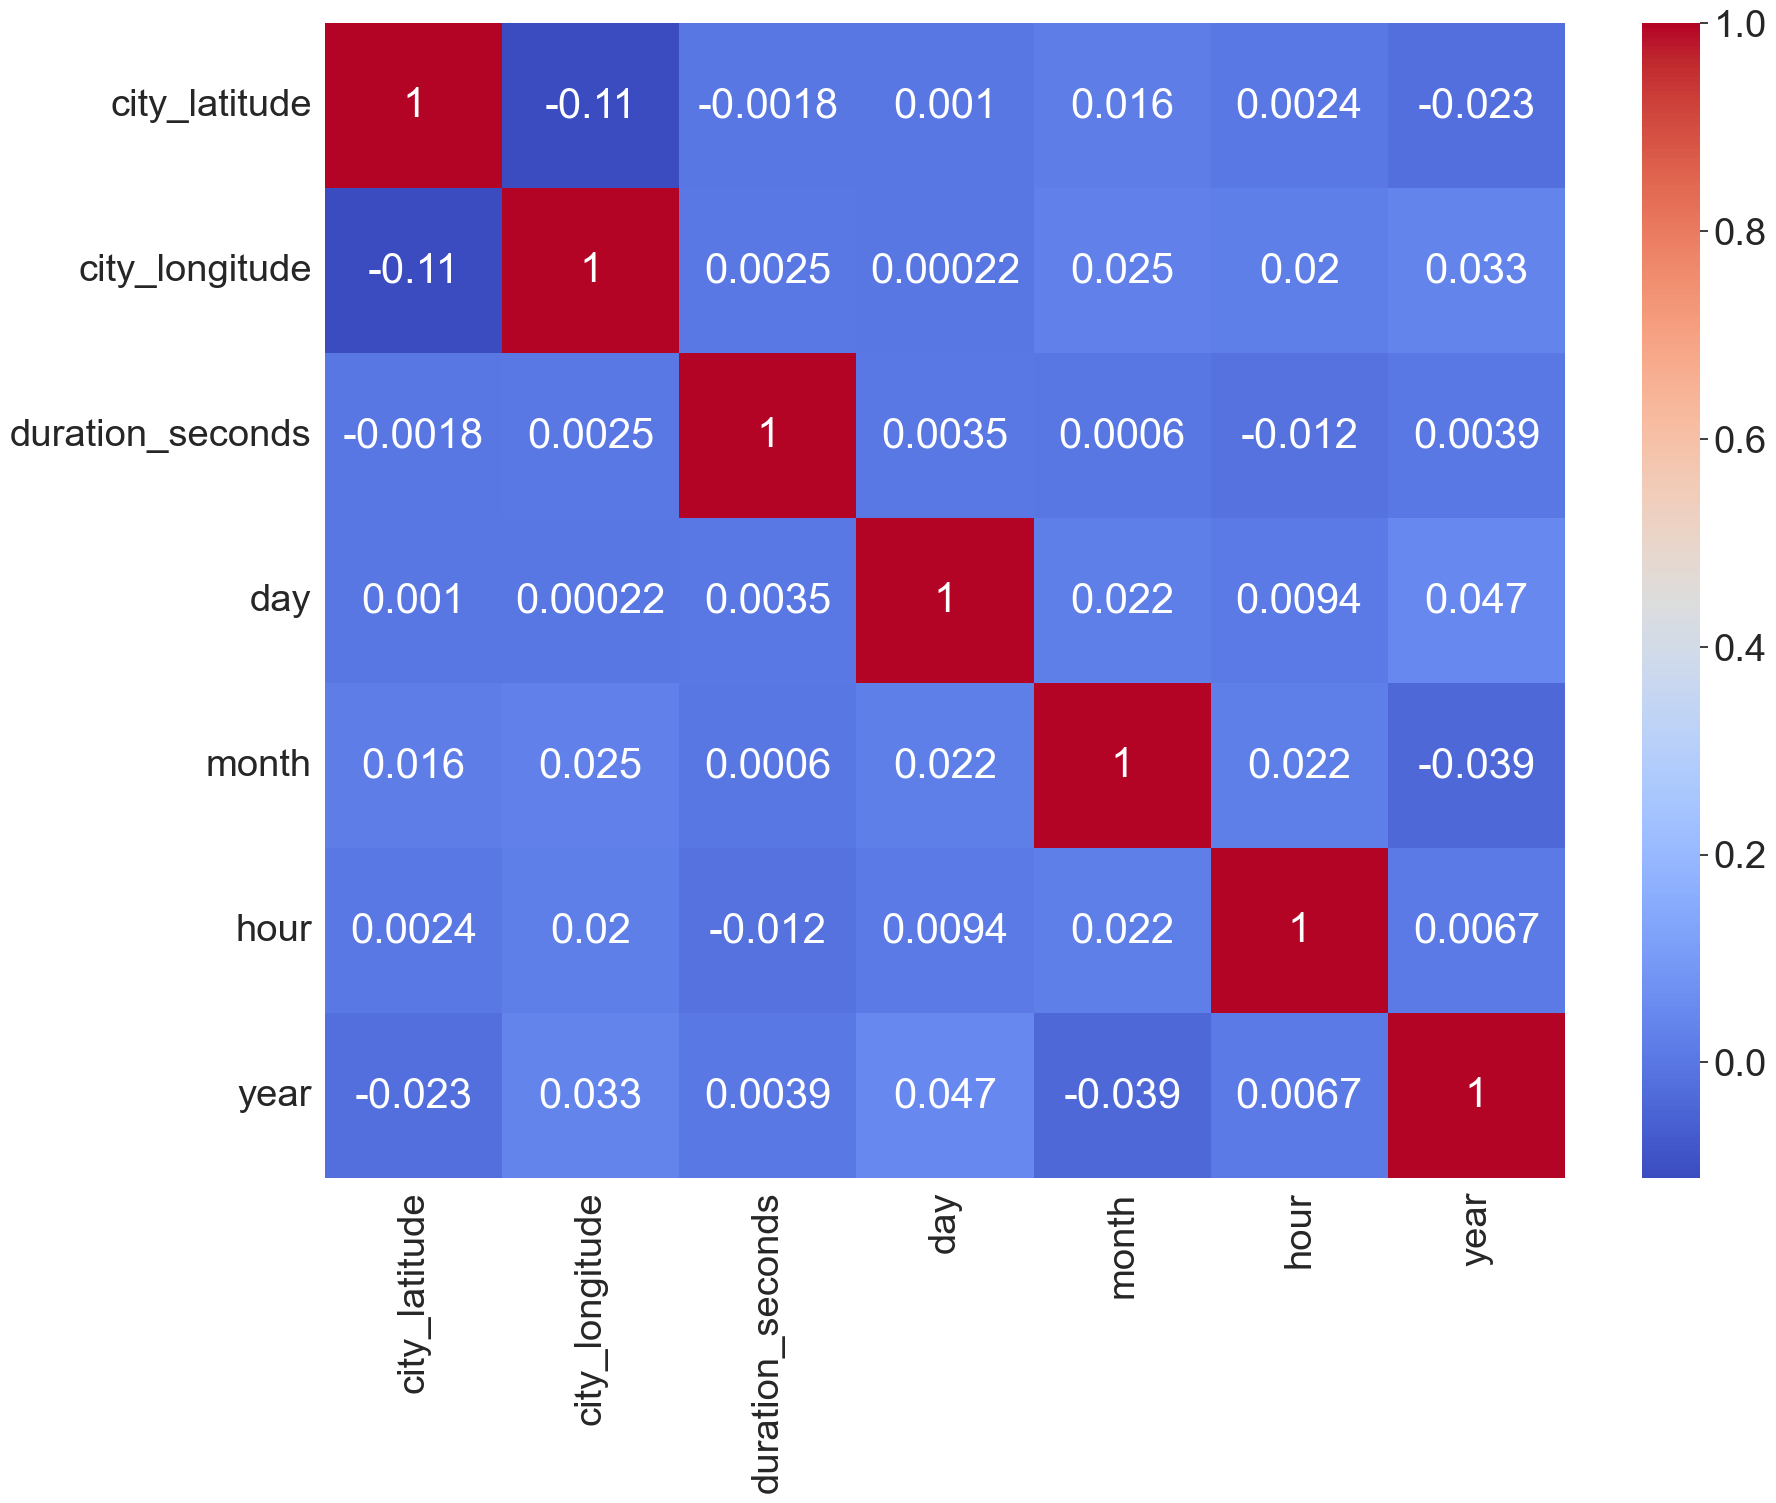

In [63]:
plt.figure(figsize=(20, 15))
sns.set(font_scale=2.5)
correlations = df.corr()
sns.heatmap(correlations, cmap="coolwarm", annot=True)
plt.show()

In [64]:
df.corr()

,city_latitude,city_longitude,duration_seconds,day,month,hour,year
city_latitude,1.000000,-0.111247,-0.001785,0.001000,0.016122,0.002358,-0.023068
city_longitude,-0.111247,1.000000,0.002515,0.000219,0.025193,0.019561,0.032706
duration_seconds,-0.001785,0.002515,1.000000,0.003533,0.000596,-0.011636,0.003948
day,0.001000,0.000219,0.003533,1.000000,0.022403,0.009378,0.047296
month,0.016122,0.025193,0.000596,0.022403,1.000000,0.021789,-0.038680
hour,0.002358,0.019561,-0.011636,0.009378,0.021789,1.000000,0.006675
year,-0.023068,0.032706,0.003948,0.047296,-0.038680,0.006675,1.000000


### No significant correlations found. 

### Frequency of Each Feature

array([[<AxesSubplot:title={'center':'city_latitude'}>,
        <AxesSubplot:title={'center':'city_longitude'}>,
        <AxesSubplot:title={'center':'duration_seconds'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'hour'}>],
       [<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'Cluster Labels'}>, <AxesSubplot:>]],
      dtype=object)

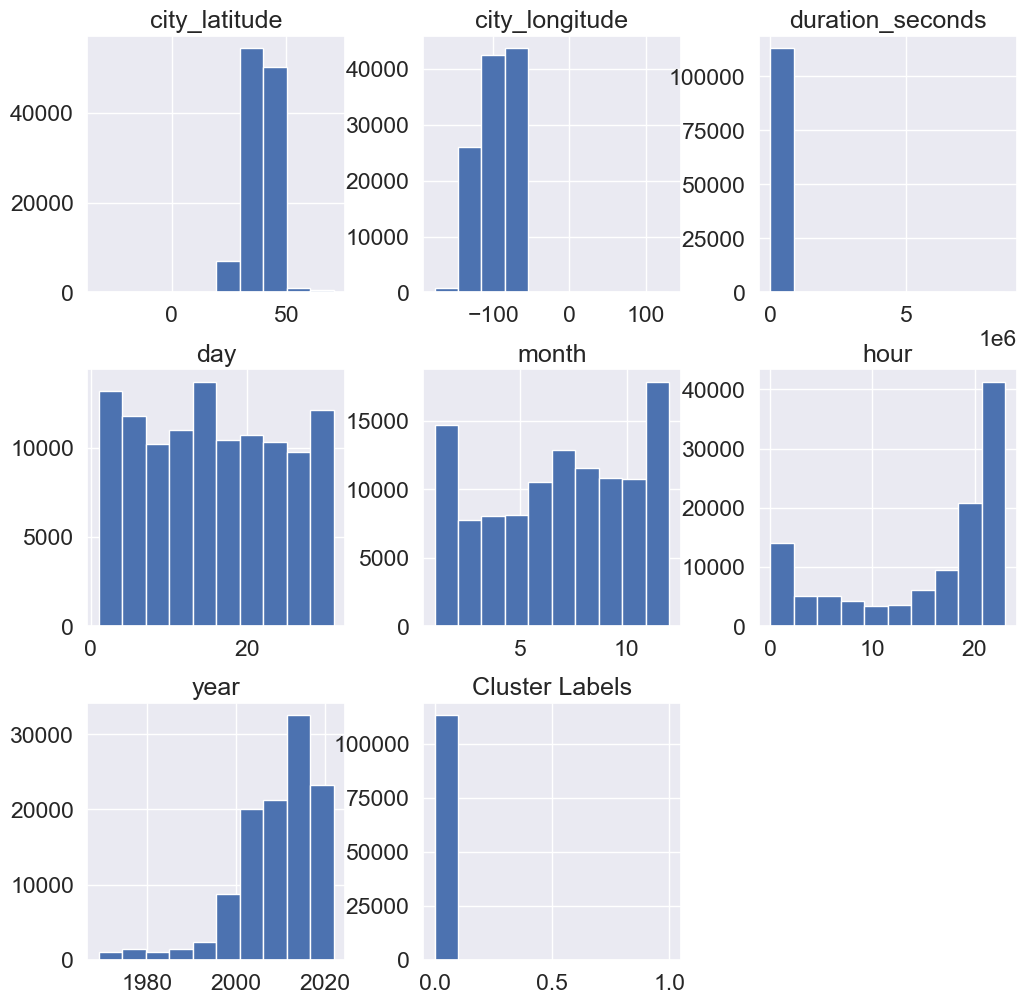

In [115]:
sns.set(font_scale=1.5)
df.hist(figsize = (12,12))

# year

[Text(0.5, 1.0, 'Number of UFO Sightings in Each Year')]

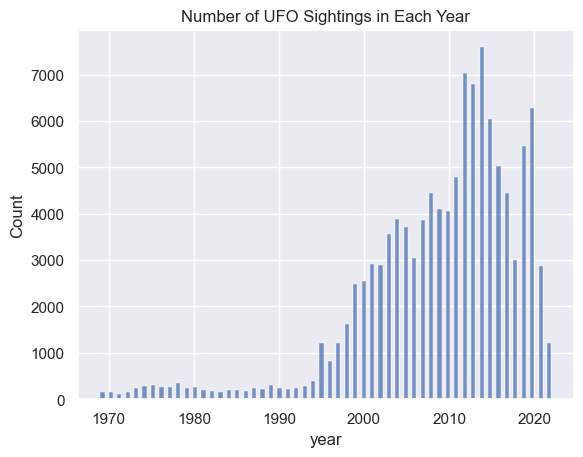

In [66]:
sns.set(font_scale=1)
sns.histplot(data=df, x="year").set(title='Number of UFO Sightings in Each Year')

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Frequency of UFO Sightings in Each Year')]

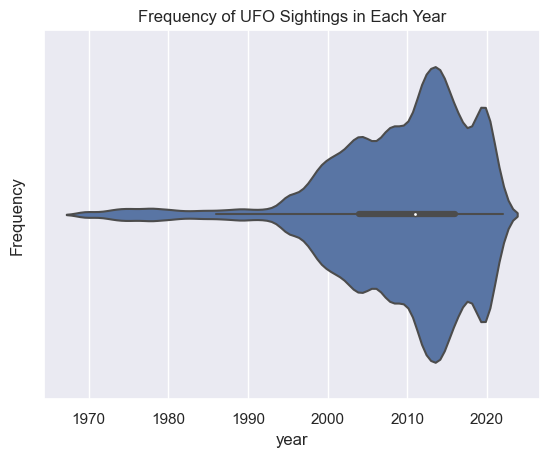

In [67]:
sns.violinplot(x='year',data= df).set(ylabel = "Frequency", title='Frequency of UFO Sightings in Each Year')

### Most reported sightings in the 2010's. 

# Shape

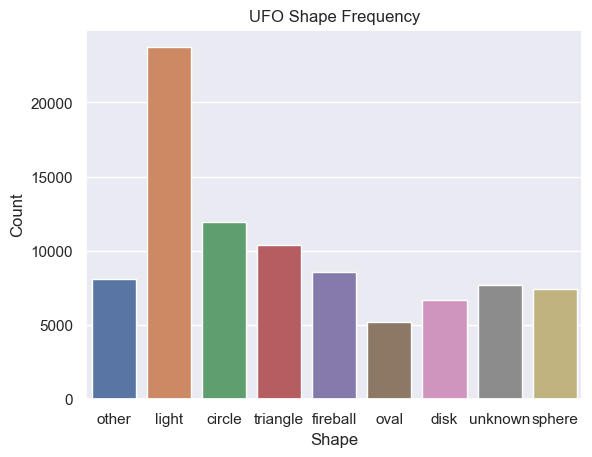

In [68]:
top_categories = df['shape'].value_counts().nlargest(9).index
df_top_shape = df[df['shape'].isin(top_categories)]

ax = sns.countplot(x="shape", data=df_top_shape)
ax.set_xlabel("Shape")
ax.set_ylabel("Count")
ax.set_title("UFO Shape Frequency")
plt.show()

### Light was the most reported UFO 'shape.' 

# duration

(0.0, 1000000.0)

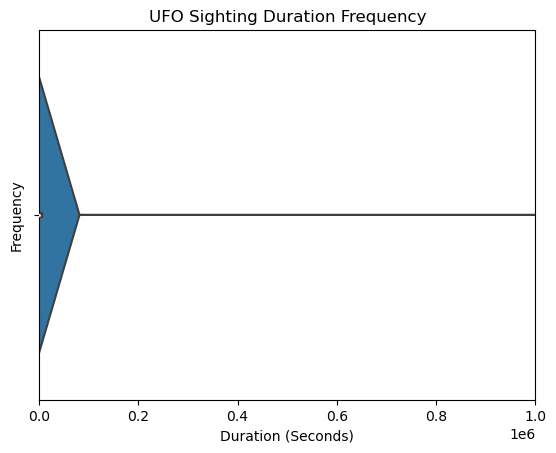

In [114]:
sns.violinplot(x='duration_seconds',data= df).set(xlabel = 'Duration (Seconds)', ylabel = "Frequency", title='UFO Sighting Duration Frequency')
plt.xlim(0, 1000000)

(0.0, 1000.0)

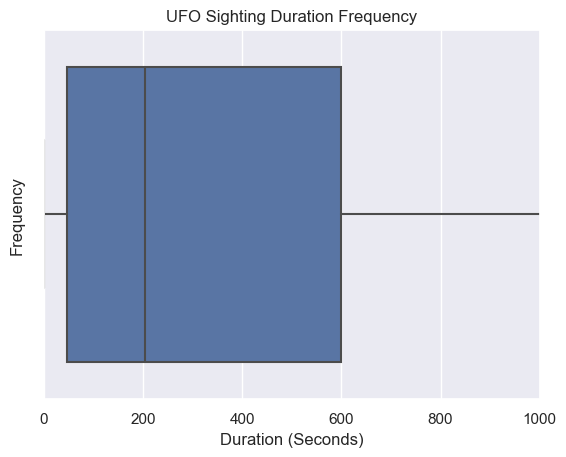

In [70]:
sns.boxplot(x='duration_seconds',data= df).set(xlabel = 'Duration (Seconds)', ylabel = "Frequency", title='UFO Sighting Duration Frequency')
plt.xlim(0, 1000)

### Most sightiings had a duration below 600 seconds (10 minutes).

# country

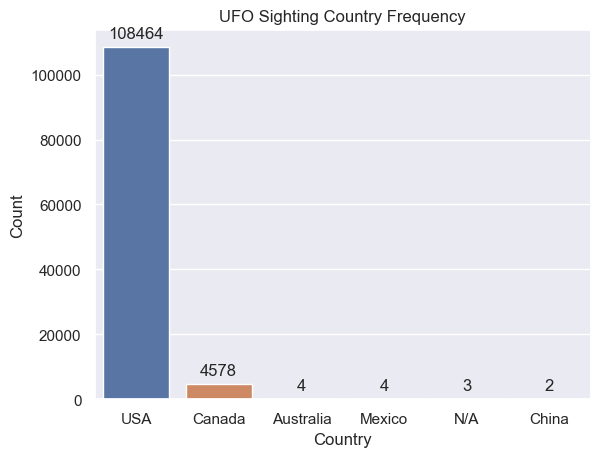

In [71]:
top_categories = df['country'].value_counts().nlargest(6).index
df_top_shape = df[df['country'].isin(top_categories)]

ax = sns.countplot(x="country", data=df_top_shape)

# Show the count for each category
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

ax.set_xlabel("Country")
ax.set_ylabel("Count")
ax.set_title("UFO Sighting Country Frequency")
plt.show()

### Large amout of report sightings in the USA (nuforc is US-based).

# Create a Map

In [72]:
#pip install geopandas

In [73]:
# import libraries
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
# import street map
usamap = gpd.read_file('/Users/ankitanambiar/Desktop/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')

In [74]:
from pyproj import CRS
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")
transformer.transform(12, 12)

(1335833.8895192828, 1345708.4084091086)

In [75]:
# designate coordinate system
usamap.crs = 'EPSG:3857'

In [76]:
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df['city_longitude'], df['city_latitude'])]

In [77]:
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df, crs = usamap.crs, geometry = geometry)
geo_df.head()

,country,city,state,shape,city_latitude,city_longitude,duration_seconds,day,month,hour,year,geometry
0,USA,Sisters,OR,cigar,44.315600,-121.517500,240.0,15,5,22,2021,POINT (-121.517 44.316)
1,USA,Sarasota,FL,other,27.354801,-82.508583,120.0,10,5,22,2021,POINT (-82.509 27.355)
2,USA,Cleveland,TN,light,35.146426,-84.851657,600.0,5,5,22,2021,POINT (-84.852 35.146)
3,USA,Galway,NY,circle,43.022500,-74.026300,2100.0,16,10,18,2020,POINT (-74.026 43.023)
4,USA,Downingtown,PA,circle,40.014600,-75.713600,3600.0,18,6,1,2021,POINT (-75.714 40.015)


In [95]:
import mpl_toolkits

In [102]:
#pip install basemap

In [98]:
import mpl_toolkits

In [100]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

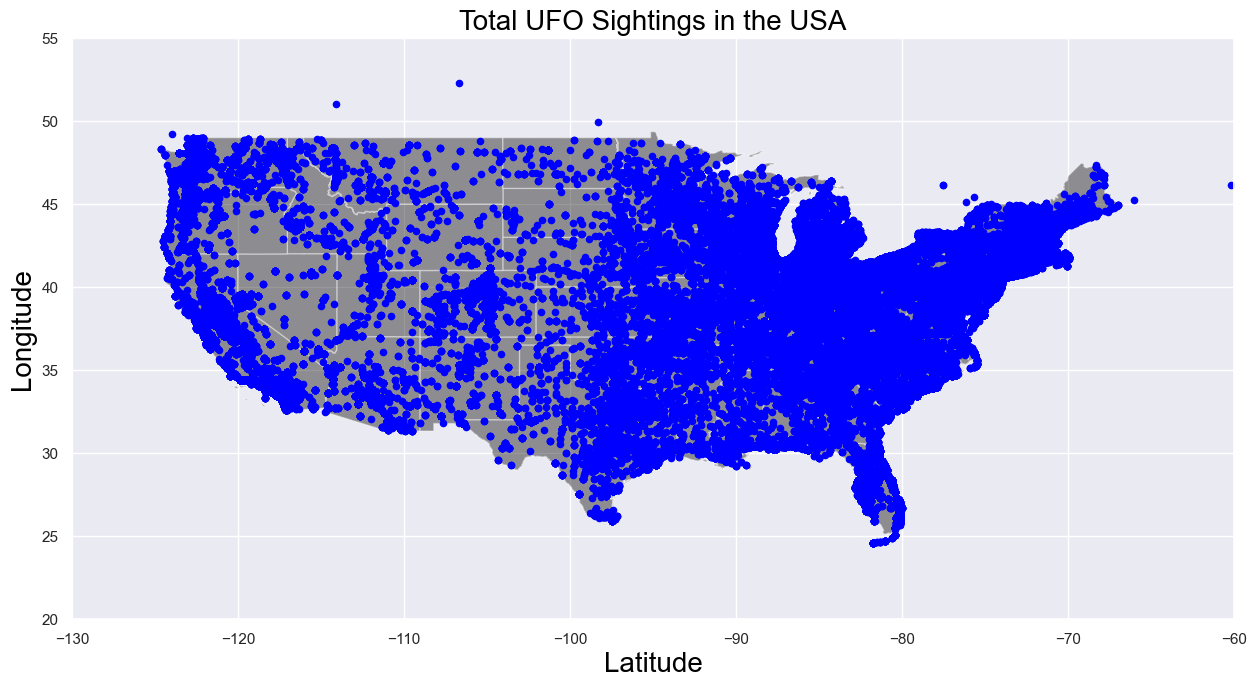

In [118]:
fig, ax = plt.subplots(figsize=(15,15))

usamap.plot(ax=ax, alpha=0.4,color='black')

geo_df[geo_df['country']=='USA'].plot(ax=ax, markersize=20, color="blue", marker = "o" )
plt.xlim(-130,-60)
plt.ylim( 20,55)

font = {'family': 'sans-serif',
        'color': 'black',
        'size': 20}

plt.xlabel("Latitude", font)
plt.ylabel("Longitude", font)
plt.title("Total UFO Sightings in the USA", font)

plt.show()

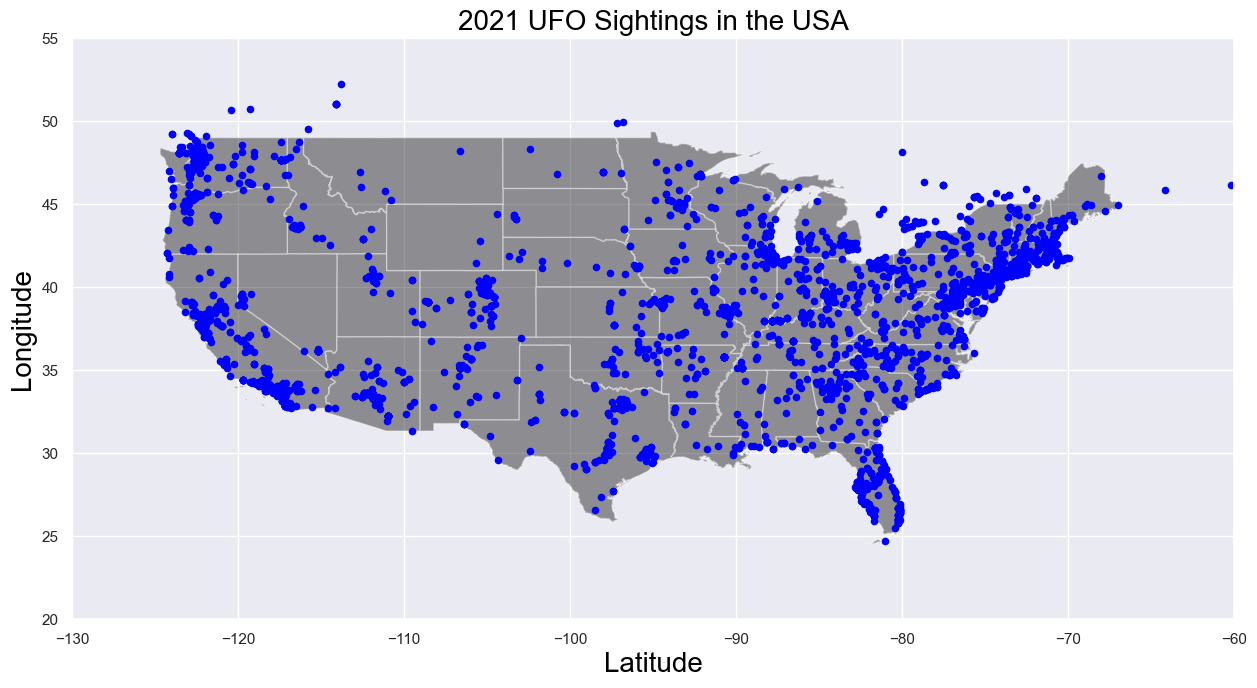

In [119]:
fig, ax = plt.subplots(figsize=(15,15))

usamap.plot(ax=ax, alpha=0.4,color='black')

geo_df[geo_df['year']==2021].plot(ax=ax, markersize=20, color= "blue", marker = "o")
plt.xlim(-130,-60)
plt.ylim( 20,55)

plt.xlabel("Latitude", font)
plt.ylabel("Longitude", font)
plt.title("2021 UFO Sightings in the USA", font)

plt.show()

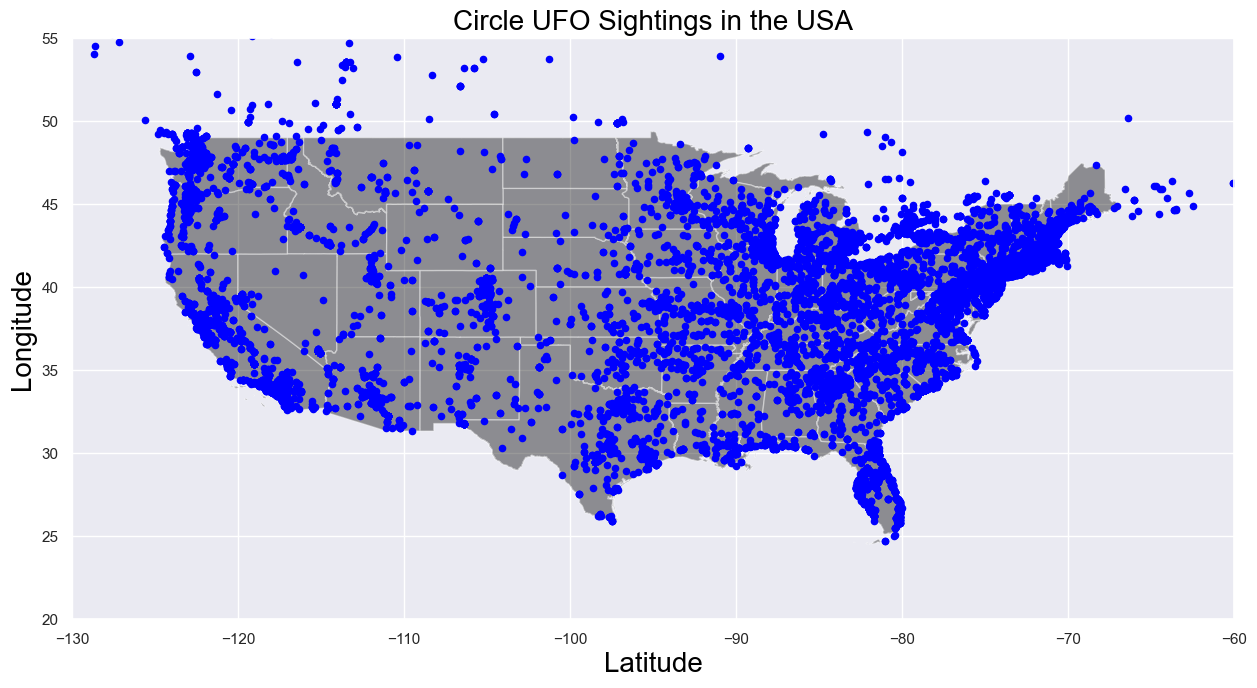

In [124]:
fig, ax = plt.subplots(figsize=(15,15))

usamap.plot(ax=ax, alpha=0.4,color='black')

geo_df[geo_df['shape']== 'circle'].plot(ax=ax, markersize=20, color= "blue", marker = "o")
plt.xlim(-130,-60)
plt.ylim( 20,55)

plt.xlabel("Latitude", font)
plt.ylabel("Longitude", font)
plt.title("Circle UFO Sightings in the USA", font)

plt.show()

# Unsupervised Learning: K-Prototype

### For this dataset, I used K-Prototype, which is a clustering technique that combines K-Means and K-Mode. K-Prototype is suitable for mixed data (data with categorical and continuous variables), which fits the current dataset. 

In [3]:
#pip install plotnine

In [68]:
#pip install kmodes

In [69]:
from kmodes.kprototypes import KPrototypes

### Feature Engineering

Only kept state, shape, duration_seconds, month, hour, and year to avoid repeated information in the dataset.

In [71]:
clustering_df = clustering_df.drop(['country','city', 'day','city_latitude','geometry', 'city_longitude'], axis=1)

In [72]:
clustering_df.head()

,state,shape,duration_seconds,month,hour,year
0,OR,cigar,240.000,5,22,2021
1,FL,other,120.000,5,22,2021
2,TN,light,600.000,5,22,2021
3,NY,circle,2100.000,10,18,2020
4,PA,circle,3600.000,6,1,2021


In [75]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113060 entries, 0 to 138017
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   state             113060 non-null  category
 1   shape             113060 non-null  category
 2   duration_seconds  113060 non-null  float64 
 3   month             113060 non-null  category
 4   hour              113060 non-null  category
 5   year              113060 non-null  category
dtypes: category(5), float64(1)
memory usage: 6.3 MB


In [73]:
cols_to_cat = ['state','shape', 'month','year', 'hour']
clustering_df[cols_to_cat] = clustering_df[cols_to_cat].astype('category')

In [80]:
catcols_Position = [clustering_df.columns.get_loc(col) for col in list(clustering_df.select_dtypes('category').columns)]

In [82]:
print('Categorical columns           : {}'.format(list(clustering_df.select_dtypes('category').columns)))
print('Categorical columns position  : {}'.format(catcols_Position))

Categorical columns           : ['state', 'shape', 'month', 'hour', 'year']
Categorical columns position  : [0, 1, 3, 4, 5]


In [83]:
dfMatrix = clustering_df.to_numpy()

### Find Optimal K Clusters

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3


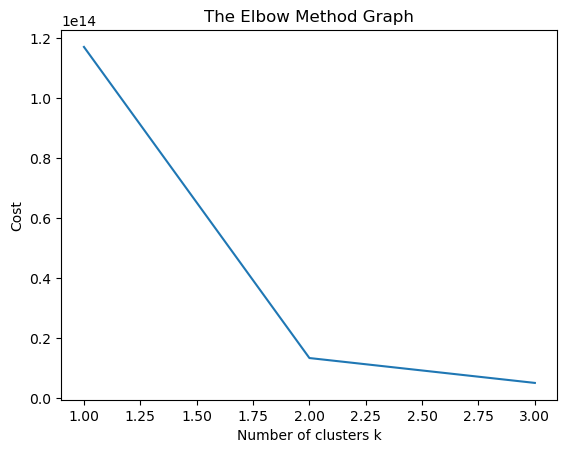

In [93]:
cost = []
for cluster in range(1, 4):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catcols_Position)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
df_cost = pd.DataFrame({'Cluster':range(1, 4), 'Cost':cost})

plt.plot(range(1,4),cost)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters k')
plt.ylabel('Cost')
plt.show()

In [94]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catcols_Position)

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [96]:
kprototype.cluster_centroids_
kprototype.n_iter_
kprototype.cost_

13339573030748.424

In [106]:
clustering_df['Cluster Labels'] = kprototype.labels_
clustering_df['Segment'] = clustering_df['Cluster Labels'].map({0:'First', 1:'Second'})
clustering_df['Segment'] = clustering_df['Segment'].astype('category')
clustering_df['Segment'] = clustering_df['Segment'].cat.reorder_categories(['First','Second'])

In [109]:
clustering_df.head()

,state,shape,duration_seconds,month,hour,year,Cluster Labels,Segment
0,OR,cigar,240.000,5,22,2021,0,First
1,FL,other,120.000,5,22,2021,0,First
2,TN,light,600.000,5,22,2021,0,First
3,NY,circle,2100.000,10,18,2020,0,First
4,PA,circle,3600.000,6,1,2021,0,First


## Clustering Results

In [113]:
clustering_df.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
clustering_df.groupby('Segment').agg(
    {
        'Total':'count',
        'state': lambda x: x.value_counts().index[0],
        'shape': lambda x: x.value_counts().index[0],
        'duration_seconds': 'mean',
        'month': lambda x: x.value_counts().index[0],
        'hour': lambda x: x.value_counts().index[0],
        'year': lambda x: x.value_counts().index[0]
    }
).reset_index()

,Segment,Total,state,shape,duration_seconds,month,hour,year
0,First,113058,CA,light,777.107,7,21,2014
1,Second,2,TN,unknown,7200070.000,7,1,2019


# Interpretation

### K-Prototype
For this dataset, I used K-Prototype, which is a clustering technique that combines K-Means and K-Mode. K-Prototype is suitable for mixed data (data with categorical and continuous variables), which is why I chose the algorithm.

### Results
After implementing K-Prototype, I found the above 2 clusters. There is something off with these clusters since the first segment has 113058 data points and the second only has 2.

The second segment was clustered separately probably due to the high duration of the points' UFO sightings. These are considered true outliers; they are extreme but represent the dataset.

### Explanation + Conclusion
A likely reason the clustering technique did not work is due to the high variation in the dataset and the lack of clear or true clustering patterns in the dataset. This is understandable as UFO sightings, in general, are not backed by any scientific research and are unnatural, random phenomenons. Furthermore, the data collection was done randomly and not validated and did not have a consistent process since they are sightings inputted by random people across the world.

For better clustering results, we need more consistent and validated data. However, that is difficult to achieve since no one knows when the UFOs will come. :)